In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rc('figure', dpi=300)

Как и в прошлом домашнем задании, будем рассматривать две функции:

1. квадратичная функция
\begin{equation*}
    f(x_1, x_2) = 100 \left(x_1 - x_2\right)^2
                    + 5 \sum_{j=2}^{n}\left(1 - x_j\right)^2;
\end{equation*}
2. функция Розенброка
\begin{equation*}
    f(x_1, x_2) = 100 \left(x_2 - x_1^2\right)^2
                    + 5\left(1 - x_1\right)^2.
\end{equation*}

In [2]:
def quadratic(*args):
    return (100 * (args[0] - args[1])**2
            + 5 * sum((1 - xi)**2 for xi in args[1:]))

def quadratic_derivatives(*args):
    derivatives = [
        200 * (args[0] - args[1]),
        -200 * (args[0] - args[1]) - 10 * (1 - args[1])
    ]
    return derivatives + [-10 * (1 - xi) for xi in args[2:]]

def rosenbrock(x1, x2):
    return 100 * (x2 - x1**2)**2 + 5 * (1 - x1)**2

def rosenbrock_derivatives(x1, x2):
    t = x2 - x1**2
    df_dx1 = -400 * x1 * t + 5 * (x1 - 1)
    df_dx2 = 200 * t
    return [df_dx1, df_dx2]

Построим их графики:

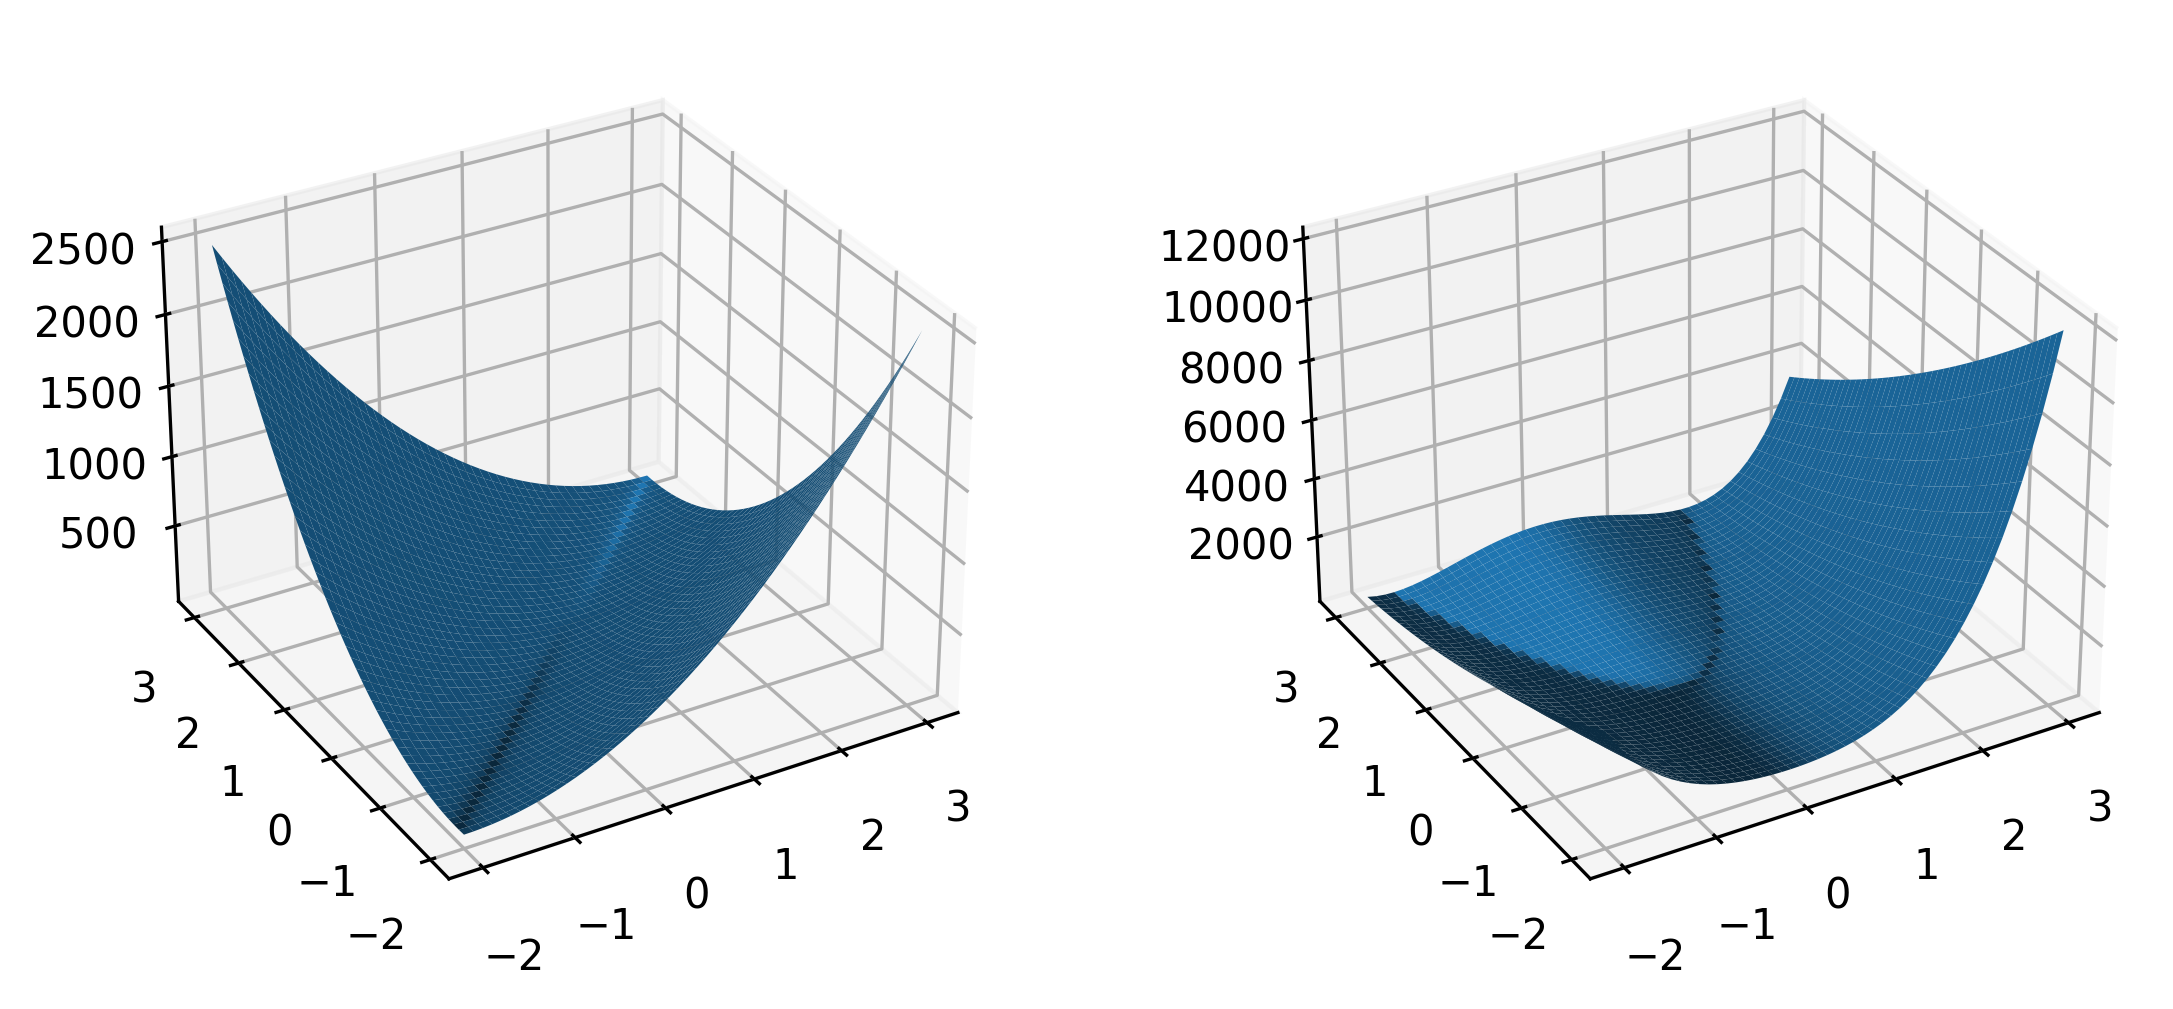

In [3]:
mesh = np.meshgrid(np.linspace(-2, 3), np.linspace(-2, 3))
fig = plt.figure(figsize=(9, 4))
ax = fig.add_subplot(121, projection='3d', azim=-120)
ax.plot_surface(*mesh, quadratic(*mesh))
ax2 = fig.add_subplot(122, projection='3d', azim=-120)
ax2.plot_surface(*mesh, rosenbrock(*mesh))

Реализуем 3 квазиньютоновских метода:
- метод Бройдена (одноранговая коррекция),
- метод Давидона-Флетчера-Пауэлла,
- метод Бройдена-Флетчера-Гольдфарба-Шенно.

В этих методах обновление текущего решения $x_k$ осуществляется по правилу
\begin{equation*}
    \vec{x}_k = \vec{x}_k - h H_k^{-1} \nabla{f(\vec{x}_k)},
\end{equation*}
где $H_k$ -- текущая аппроксимация Гессиана $\nabla\nabla{f(\vec{x}_k)}$.
Эта аппроксимация, в свою очередь, обновляется на каждой итерации с помощью
векторов $\vec{\delta}_k = \vec{x}_{k+1} - \vec{x}_k$ и
$\vec{\gamma}_k = \nabla{f(\vec{x}_{k+1})} - \nabla{f(\vec{x}_k)}$.

Как и в прошлой работе, значение коэффициента $h$ может выбираться одним из 3 способов.
Соответствующие функции представлены ниже.

In [4]:
def golden_section_search(f, a, b, atol=None):
    """
    Найти минимум функции `f` на интервале [`a`, `b`] с точностью `atol`
    методом золотого сечения. Точность по умолчанию `1e-4 * (b - a)`.
    """
    # точность по умолчанию
    if atol is None:
        atol = (b - a) * 1e-4
    # коэффициент для разбиения отрезка
    phi = (np.sqrt(5) - 1) / 2

    # начальное разбиение
    c = b - (b - a) * phi
    f_c = f(c)
    d, f_d = None, None

    while (b - a) > atol:
        # новая точка
        if c is None:
            c = b - (b - a) * phi
            f_c = f(c)
        else:
            assert d is None
            d = a + (b - a) * phi
            f_d = f(d)

        # выбор нового интервала
        if f_c < f_d:
            b, d = d, c
            f_d = f_c
            c = None
        else:
            a, c = c, d
            f_c = f_d
            d = None

    return a + (b - a) / 2

In [5]:
def choose_h(f, x, grad, h_method):
    if h_method == 'min':
        # поиск h из условия минимума
        h = 1.0
        f_x = f(*x)
        while True:
            h = golden_section_search(
                lambda h: f(*(x_i - h * grad_x_i
                            for x_i, grad_x_i in zip(x, grad))),
                a=0,
                b=h
            )
            if f(*(x - h * grad)) < f_x:
                break
    elif isinstance(h_method, (int, float)):
        # постоянное значение h
        h = h_method
    else:
        # поиск h через двойное неравенство
        assert len(h_method) == 2
        alpha = h_method[0]
        beta = h_method[1]
        h_min, h_max = 0, 1
        grad_norm = np.linalg.norm(grad)
        f_x = f(*x)
        h = 1

        # двоичный поиск
        while True:
            decrease = f_x - f(*(x - grad * h))
            dot_product = grad_norm**2 * h
            if alpha * dot_product > decrease:
                h_max = h
            elif beta * dot_product < decrease:
                h_min = h
            else:
                break
            h = (h_min + h_max) / 2

    return h

# Метод Бройдена

In [6]:
def broyden(f, fdot, x0, h_method=1e-3, grad_min=1e-4, restart_period=1,
            maxiter=10000, full_output=True):
    # инициализация
    n = len(x0)                      # размерность пространства
    x = np.array(x0, dtype='float')  # текущее решение
    H = np.eye(n)                    # (аппроксимация Гессиана)^-1
    grad = np.array(fdot(*x))        # градиент
    solutions = [x.copy()]           # все решения
    num_iterations = 0               # число итераций после рестарта

    while np.linalg.norm(grad) >= grad_min:
        # рестарт
        if num_iterations == n * restart_period:
            H = np.eye(n)
            num_iterations = 0

        h = choose_h(f, x, grad, h_method)

        # обновляем решение
        delta = -h * np.dot(H, grad)
        x += delta
        solutions.append(x.copy())
        g_new = np.array(fdot(*x))
        gamma = g_new - grad
        grad = g_new

        # обновляем H
        residual = delta - np.dot(H, gamma)
        H += np.outer(residual, residual) / np.dot(residual, gamma)
        num_iterations += 1

        # проверяем полное число итераций
        if len(solutions) >= maxiter:
            raise Exception(
                f'Решение не сошлось после {maxiter} итераций.')

    if full_output:
        return solutions
    return x

In [7]:
sol = broyden(quadratic, quadratic_derivatives, [0, 0],
              h_method=1, grad_min=1e-3, restart_period=2, full_output=True)
print('Квадратичная функция, n = 2:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = broyden(quadratic, quadratic_derivatives, [0] * 5,
              h_method=1, grad_min=1e-3, restart_period=2, full_output=True)
print('\nКвадратичная функция, n = 5:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = broyden(rosenbrock, rosenbrock_derivatives, [0, 0],
              h_method='min', grad_min=1e-3, restart_period=2, full_output=True)
print('\nФункция Розенброка:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')


Квадратичная функция, n = 2:
x = [1. 1.]
число итераций: 3

Квадратичная функция, n = 5:
x = [1. 1. 1. 1. 1.]
число итераций: 4

Функция Розенброка:
x = [0.99955512 0.99910615]
число итераций: 278


# Метод Давидона-Флетчера-Пауэлла

In [8]:
def dfp(f, fdot, x0, h_method=1.0, grad_min=1e-4, maxiter=10000,
        full_output=True):
    # инициализация
    n = len(x0)                      # размерность пространства
    x = np.array(x0, dtype='float')  # текущее решение
    H = np.eye(n)                    # (аппроксимация Гессиана)^-1
    grad = np.array(fdot(*x))        # градиент
    solutions = [x.copy()]           # все решения

    while np.linalg.norm(grad) >= grad_min:
        h = choose_h(f, x, grad, h_method)

        # обновляем решение
        delta = -h * np.dot(H, grad)
        x += delta
        solutions.append(x.copy())
        g_new = np.array(fdot(*x))
        gamma = g_new - grad
        grad = g_new

        # обновляем H
        u = np.dot(H, gamma)
        H += (1 / np.dot(gamma, delta) * np.outer(delta, delta)
              - 1 / np.dot(u, gamma) * np.outer(np.dot(H, gamma), u))

        # проверяем полное число итераций
        if len(solutions) >= maxiter:
            raise Exception(
                f'Решение не сошлось после {maxiter} итераций.')

    if full_output:
        return solutions
    return x

In [9]:
sol = dfp(quadratic, quadratic_derivatives, [0, 0],
          h_method=1, grad_min=1e-3, full_output=True)
print('\nКвадратичная функция, n = 2:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = dfp(quadratic, quadratic_derivatives, [0] * 5,
          h_method=1, grad_min=1e-3, full_output=True)
print('\nКвадратичная функция, n = 5:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = dfp(rosenbrock, rosenbrock_derivatives, [0, 0],
          h_method=0.1, grad_min=1e-3, full_output=True)
print('\nФункция Розенброка:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')



Квадратичная функция, n = 2:
x = [1.00000001 0.99999999]
число итераций: 5

Квадратичная функция, n = 5:
x = [0.9999999  1.00000005 1.00000052 1.00000052 1.00000052]
число итераций: 7

Функция Розенброка:
x = [0.99996776 0.99993307]
число итераций: 122


# Метод Бройдена-Флетчера-Гольдфарба-Шенно

In [10]:
def bfgs(f, fdot, x0, h_method=1.0, grad_min=1e-4, maxiter=10000,
         full_output=True):
    # инициализация
    n = len(x0)                      # размерность пространства
    x = np.array(x0, dtype='float')  # текущее решение
    H = np.eye(n)                    # (аппроксимация Гессиана)^-1
    grad = np.array(fdot(*x))        # градиент
    solutions = [x.copy()]           # все решения

    while np.linalg.norm(grad) >= grad_min:
        h = choose_h(f, x, grad, h_method)

        # обновляем решение
        delta = -h * np.dot(H, grad)
        x += delta
        solutions.append(x.copy())
        g_new = np.array(fdot(*x))
        gamma = g_new - grad
        grad = g_new

        # обновляем H
        u = np.dot(H, gamma)
        m = np.dot(u, gamma)
        G = np.outer(u, delta)
        H += (1 / m * (G + G.T)
              - 1 / m * (1 + np.dot(gamma, delta) / m) * np.outer(u, u))

        # проверяем полное число итераций
        if len(solutions) >= maxiter:
            raise Exception(
                f'Решение не сошлось после {maxiter} итераций.')

    if full_output:
        return solutions
    return x

In [11]:
sol = bfgs(quadratic, quadratic_derivatives, [0, 0],
           h_method=1, grad_min=1e-3, full_output=True)
print('\nКвадратичная функция, n = 2:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = bfgs(quadratic, quadratic_derivatives, [0] * 5,
           h_method=1, grad_min=1e-3, full_output=True)
print('\nКвадратичная функция, n = 5:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')

sol = bfgs(rosenbrock, rosenbrock_derivatives, [0, 0],
           h_method=1, grad_min=1e-3, full_output=True)
print('\nФункция Розенброка:')
print(f'x = {sol[-1]}')
print(f'число итераций: {len(sol) - 1}')



Квадратичная функция, n = 2:
x = [1. 1.]
число итераций: 5

Квадратичная функция, n = 5:
x = [0.99999451 0.99999478 1.00001413 1.00001413 1.00001413]
число итераций: 7

Функция Розенброка:
x = [0.99999961 0.99999896]
число итераций: 99
